In [1]:
import pandas as pd
import torch
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import TensorDataset, DataLoader
import os
import cv2 as cv
from torch.utils.data import Dataset
from torchvision import transforms
import torch.nn.functional as F
from PIL import Image
import torch.nn as nn
from torch.optim import Adam
import matplotlib.pyplot as plt
import numpy as np
from torch.autograd import Variable

# Define the data and label

In [101]:
def getlabel(dir):
    labels=[]
    for name in os.listdir(dir):
        if os.path.splitext(name)[1] == '.png':
            fname=os.path.splitext(name)[0]
            labels.append(fname)
    labels = list(map(int, labels))
    return torch.tensor(labels)

def generate_dataset(dir):
    """
    set_label should be 'torch.tensor([1])' if two-catogory and positive sample
    """
    train_data = []
    for file_name in os.listdir(dir):
        img_dir = os.path.join(dir, file_name)
        img = cv.imread(img_dir)
        img = cv.resize(img, (769, 432))   # /5 resize img
        #img_gray = cv.cvtColor(img,cv.COLOR_RGB2GRAY)
        pimg = Image.fromarray(img)
        train_data.append(pimg)
    return train_data

In [102]:
traindir= './train/'
validdir = './test/'
train_data = generate_dataset(traindir)
train_label=getlabel(traindir)
valid_data = generate_dataset(validdir)
valid_label = getlabel(validdir)

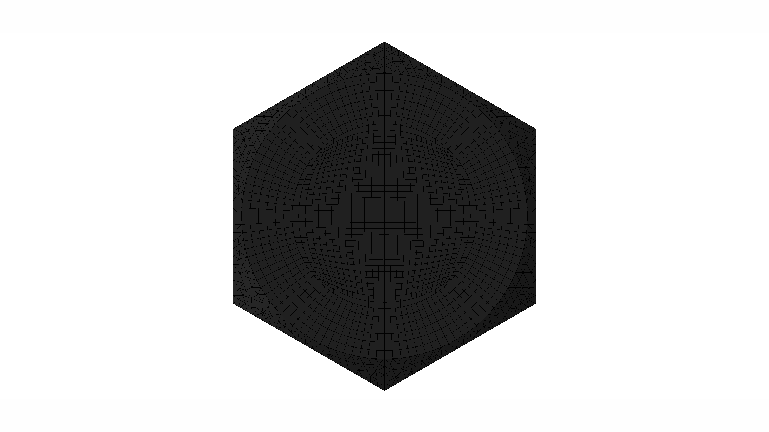

In [103]:
train_data[1]

# 重写dataset类

In [104]:
class MyDataset(Dataset):
    def __init__(self, data, labels, transform=None, target_transform=None):
        self.transform = transform
        self.target_transform = target_transform
        imgs = []
        for i in range(len(labels)):
            # print(type(data[i]))    # <class 'PIL.Image.Image'>
            im_tensor = transform(data[i]).to(torch.device("cpu"))
            imgs.append((im_tensor, labels[i]))
        self.imgs = imgs                         # DataLoader通过getitem读取图片数据
    def __getitem__(self, index):
        fn, label = self.imgs[index]
        return fn, label
    def __len__(self):
        return len(self.imgs)
    

# 用MyDataset构建数据集

In [105]:
normMean = [0.35174567, 0.4027052, 0.39986762]
normStd = [0.18738173, 0.17127964, 0.1971462]
transform = transforms.Compose(
    [transforms.Grayscale(num_output_channels=1), #彩色图像转灰度图像num_output_channels默认1
    transforms.ToTensor(),  # range [0, 255] -> [0.0,1.0]   
    #transforms.Normalize(normMean, normStd)
    ])
# 也可以再定义train_transform加入一些数据增强 
train_data = MyDataset(train_data, train_label, transform=transform)
valid_data = MyDataset(valid_data, valid_label, transform=transform)
train_loader = DataLoader(dataset=train_data, batch_size=2, shuffle=True)
test_loader = DataLoader(dataset=valid_data, batch_size=2, shuffle=True)

In [154]:
dataiter=iter(train_loader)
images, labels = dataiter.next()
print(images.shape)
print(labels.shape)

torch.Size([2, 1, 432, 769])
torch.Size([2])


# creat BP-NN

In [208]:
# Define a convolution neural network
class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=3, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(3)
        self.conv2 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(6)
        self.pool = nn.MaxPool2d(2,2)
        self.fc1 = nn.Linear(6*108*192, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, input):
        output = self.pool(F.relu(self.bn1(self.conv1(input))))      #432-3+1=430,430/2=215;769-3+1=767,767/2=384
        output = F.relu(self.bn2(self.conv2(output)))                #215-3+1=213,213/2=108;384-3+1=382,382/2=192
        output = self.pool(output)   
        output = output.view(-1, 6*108*192)
        #output = torch.flatten(x, 1)                        
        #output = output.view(output.size(0), -1)
        output = F.relu(self.fc1(output))
        output = F.relu(self.fc2(output))
        output = self.fc3(output)

        return output
model = Network()

# Defin Loss Function

In [109]:

 
# Define the loss function with Classification Cross-Entropy loss and an optimizer with Adam optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=0.001, weight_decay=0.0001)

In [172]:

# Function to save the model
def saveModel():
    path = "./myFirstModel.pth"
    torch.save(model.state_dict(), path)

# Function to test the model with the test dataset and print the accuracy for the test images
def testAccuracy():
    
    model.eval()
    accuracy = 0.0
    total = 0.0
    
    with torch.no_grad():
        for data in test_loader:
            images, labels = data
            # run the model on the test set to predict labels
            outputs = model(images)
            # the label with the highest energy will be our prediction
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            accuracy += (predicted == labels).sum().item()
    
    # compute the accuracy over all test images
    accuracy = (100 * accuracy / total)
    return(accuracy)


# Training function. We simply have to loop over our data iterator and feed the inputs to the network and optimize.
def train(num_epochs):
    
    best_accuracy = 0.0

    # Define your execution device
    #device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    device = torch.device("cpu")
    print("The model will be running on", device, "device")
    # Convert model parameters and buffers to CPU or Cuda
    model.to(device)

    for epoch in range(num_epochs):  # loop over the dataset multiple times
        running_loss = 0.0
        running_acc = 0.0

        for i, (images, labels) in enumerate(train_loader, 0):
            
            # get the inputs
            images = Variable(images.to(device))
            labels = Variable(labels.to(device))
            print(images.shape)
            print(labels.shape)
            # zero the parameter gradients
            optimizer.zero_grad()
            # predict classes using images from the training set
            outputs = model(images)
            # compute the loss based on model output and real labels
            loss = loss_fn(outputs, labels)
            # backpropagate the loss
            loss.backward()
            # adjust parameters based on the calculated gradients
            optimizer.step()

            # Let's print statistics for every 1,000 images
            running_loss += loss.item()     # extract the loss value
            if i % 1000 == 999:    
                # print every 1000 (twice per epoch) 
                print('[%d, %5d] loss: %.3f' %
                      (epoch + 1, i + 1, running_loss / 1000))
                # zero the loss
                running_loss = 0.0

        # Compute and print the average accuracy fo this epoch when tested over all 10000 test images
        accuracy = testAccuracy()
        print('For epoch', epoch+1,'the test accuracy over the whole test set is %d %%' % (accuracy))
        
        # we want to save the model if the accuracy is the best
        if accuracy > best_accuracy:
            saveModel()
            best_accuracy = accuracy
    print('Finished Training')

# test

In [112]:
# Function to show the images
def imageshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# Function to test the model with a batch of images and show the labels predictions
def testBatch():
    # get batch of images from the test DataLoader  
    images, labels = next(iter(test_loader))

    # show all images as one image grid
    imageshow(torchvision.utils.make_grid(images))
   
    # Show the real labels on the screen 
    print('Real labels: ', ' '.join('%5s' % classes[labels[j]] 
                               for j in range(batch_size)))
  
    # Let's see what if the model identifiers the  labels of those example
    outputs = model(images)
    
    # We got the probability for every 10 labels. The highest (max) probability should be correct label
    _, predicted = torch.max(outputs, 1)
    
    # Let's show the predicted labels on the screen to compare with the real ones
    print('Predicted: ', ' '.join('%5s' % classes[predicted[j]] 
                              for j in range(batch_size)))

print(torch.Size(labels))
print(torch.Size(labels))

In [209]:
if __name__ == "__main__":

    torch.cuda.empty_cache()
    torch.cuda.memory_summary(device=None, abbreviated=False)
    # Let's build our model
    train(10)
    print('Finished Training')

    # Test which classes performed well
    testAccuracy()
    
    # Let's load the model we just created and test the accuracy per label
    model = Network()
    path = "myFirstModel.pth"
    model.load_state_dict(torch.load(path))

    # Test with batch of images
    testBatch()
    #https://discuss.pytorch.org/t/indexerror-target-2-is-out-of-bounds/69614/13

The model will be running on cpu device
torch.Size([2, 1, 432, 769])
torch.Size([2])


IndexError: Target 41 is out of bounds.